Starting training on solid object...
Epoch 0, Loss: 0.600507
Epoch 1000, Loss: 0.000012
Epoch 2000, Loss: 0.000016
Epoch 3000, Loss: 0.000007
Epoch 4000, Loss: 0.000073
Epoch 5000, Loss: 0.000033
Epoch 6000, Loss: 0.000001
Epoch 7000, Loss: 0.000003
Epoch 8000, Loss: 0.000009
Epoch 9000, Loss: 0.000079


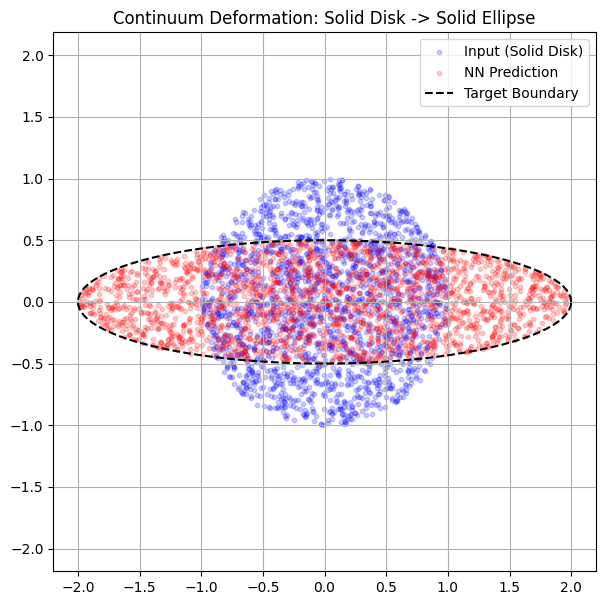

In [3]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Generation (Updated for Solid Disk -> Solid Ellipse)
def generate_data(n_samples=2000):
    key = jax.random.PRNGKey(0)
    k1, k2 = jax.random.split(key)
    
    # Random angle: 0 to 2pi
    theta = jax.random.uniform(k1, (n_samples, 1), minval=0, maxval=2*jnp.pi)
    
    # Random radius: 0 to 1
    # NOTE: To sample uniformly over a disk area, we take sqrt of uniform distribution.
    # If we didn't do sqrt, points would cluster in the center.
    r = jnp.sqrt(jax.random.uniform(k2, (n_samples, 1), minval=0, maxval=1.0))
    
    # Input: Points inside Unit Circle
    x = r * jnp.cos(theta)
    y = r * jnp.sin(theta)
    inputs = jnp.concatenate([x, y], axis=1) # Shape (N, 2)
    
    # Target: Points inside Oval (Deformation Field)
    # The continuum mapping is x_new = 2*x, y_new = 0.5*y
    x_target = 2.0 * x
    y_target = 0.5 * y
    targets = jnp.concatenate([x_target, y_target], axis=1) # Shape (N, 2)
    
    return inputs, targets

# 2. Model Definition (Flax)
class DeformNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        # A simple MLP to learn the non-linear mapping
        x = nn.Dense(features=64)(x)
        x = nn.tanh(x)              
        x = nn.Dense(features=64)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=2)(x) # Output: (x', y')
        return x

# 3. Train State & Loss
def create_train_state(rng, learning_rate):
    model = DeformNet()
    params = model.init(rng, jnp.ones([1, 2]))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch_inputs, batch_targets):
    def loss_fn(params):
        predictions = state.apply_fn({'params': params}, batch_inputs)
        # Mean Squared Error Loss
        loss = jnp.mean((predictions - batch_targets) ** 2)
        return loss
    
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

# 4. Main Execution
def main():
    # Setup - Increased samples slightly to visualize the area better
    inputs, targets = generate_data(n_samples=2000)
    rng = jax.random.PRNGKey(42)
    rng, init_rng = jax.random.split(rng)
    
    state = create_train_state(init_rng, learning_rate=0.01)
    
    # Training Loop
    epochs = 10000
    loss_history = []
    
    print("Starting training on solid object...")
    for epoch in range(epochs):
        state, loss = train_step(state, inputs, targets)
        loss_history.append(loss)
        
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.6f}")

    # 5. Evaluation & Visualization
    
    # Generate a grid of test points to visualize the field transformation
    # We use the original inputs as test points to see where the NN maps them
    predicted_oval = state.apply_fn({'params': state.params}, inputs)

    # Plot results
    plt.figure(figsize=(7, 7))
    
    # Plot 1: The Input (Unit Disk)
    plt.scatter(inputs[:, 0], inputs[:, 1], 
                alpha=0.2, color='blue', s=10, label='Input (Solid Disk)')
    
    # Plot 2: The Neural Network Prediction
    # We plot this on top. If the model works, this should look like the target ellipse.
    plt.scatter(predicted_oval[:, 0], predicted_oval[:, 1], 
                alpha=0.2, color='red', s=10, label='NN Prediction')

    # Optional: Plot the Target boundary just for reference
    theta_boundary = jnp.linspace(0, 2*jnp.pi, 100)
    plt.plot(2.0*jnp.cos(theta_boundary), 0.5*jnp.sin(theta_boundary), 
             color='black', linestyle='--', label='Target Boundary')

    plt.legend()
    plt.title("Continuum Deformation: Solid Disk -> Solid Ellipse")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

Training Hybrid Model (C1=0.5, D1=5.0)...
Step 0 | LR: 0.001000 | Loss: 6.24089 | Energy: 0.00000
Step 500 | LR: 0.000997 | Loss: 0.95896 | Energy: 0.82033
Step 1000 | LR: 0.000989 | Loss: 0.95750 | Energy: 0.81924
Step 1500 | LR: 0.000976 | Loss: 0.95548 | Energy: 0.81755
Step 2000 | LR: 0.000957 | Loss: 0.94138 | Energy: 0.80044
Step 2500 | LR: 0.000934 | Loss: 0.55218 | Energy: 0.43188
Step 3000 | LR: 0.000905 | Loss: 0.35706 | Energy: 0.27667
Step 3500 | LR: 0.000873 | Loss: 0.30720 | Energy: 0.24875
Step 4000 | LR: 0.000836 | Loss: 0.28592 | Energy: 0.23999
Step 4500 | LR: 0.000796 | Loss: 0.27779 | Energy: 0.23353
Step 5000 | LR: 0.000753 | Loss: 0.25418 | Energy: 0.21355
Step 5500 | LR: 0.000706 | Loss: 0.09644 | Energy: 0.07115
Step 6000 | LR: 0.000658 | Loss: 0.02893 | Energy: 0.01562
Step 6500 | LR: 0.000608 | Loss: 0.01315 | Energy: 0.00509
Step 7000 | LR: 0.000557 | Loss: 0.00901 | Energy: 0.00313
Step 7500 | LR: 0.000505 | Loss: 0.00760 | Energy: 0.00268
Step 8000 | LR: 0.

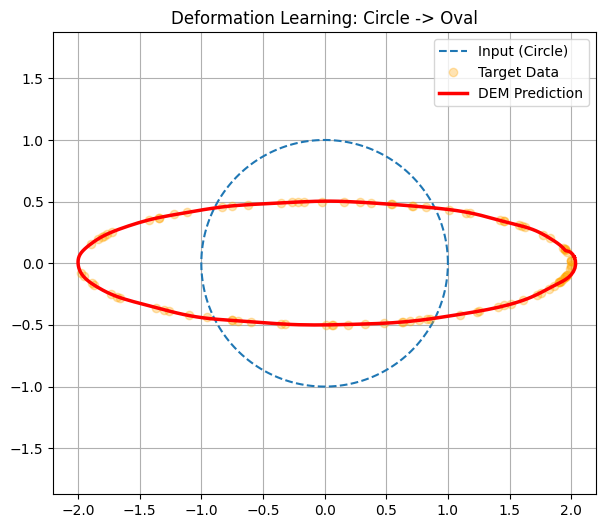

In [26]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt

# --- 1. Material Constants (From your formula image) ---
C1 = 0.5   # Corresponds to shear modulus
D1 = 5.0   # Penalty for volume change (compressibility)

# --- 2. Data Generation ---
def get_data(n_boundary=100, n_domain=1500, key=jax.random.PRNGKey(0)):
    k1, k2 = jax.random.split(key)
    
    # A. Boundary Data (Supervised)
    # We use this to force the shape to become an Oval
    theta = jax.random.uniform(k1, (n_boundary, 1), minval=0, maxval=2*jnp.pi)
    # Sort theta for cleaner plotting lines later
    theta = jnp.sort(theta, axis=0) 
    
    X_b = jnp.concatenate([jnp.cos(theta), jnp.sin(theta)], axis=1) # Circle
    x_b_target = jnp.concatenate([2.0 * jnp.cos(theta), 0.5 * jnp.sin(theta)], axis=1) # Oval
    
    # B. Domain Data (Physics/DEM)
    # Random points INSIDE the circle to enforce energy minimization
    r = jnp.sqrt(jax.random.uniform(k2, (n_domain, 1), minval=0, maxval=1))
    theta_d = jax.random.uniform(k2, (n_domain, 1), minval=0, maxval=2*jnp.pi)
    X_domain = jnp.concatenate([r * jnp.cos(theta_d), r * jnp.sin(theta_d)], axis=1)
    
    return X_b, x_b_target, X_domain

# --- 3. The Model ---
class HyperElasticNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Initialize hidden layers
        init_w = nn.initializers.variance_scaling(0.01, mode='fan_in', distribution='truncated_normal')
        
        y = nn.Dense(64, kernel_init=init_w)(x)
        y = nn.tanh(y) 
        y = nn.Dense(64, kernel_init=init_w)(y)
        y = nn.tanh(y)
        
        # FIX: Use nn.initializers.zeros to fix the TypeError
        u = nn.Dense(2, kernel_init=nn.initializers.zeros)(y) 
        return u

# --- 4. Custom Energy Function (Matches your Screenshot) ---
def custom_energy(model_apply, params, x):
    """
    Equation: W = C1(I1 - 2 - 2ln(J)) + D1(J - 1)^2
    Note: Using (I1 - 2) for 2D as requested.
    """
    # 1. Kinematics: x -> x + u
    def deformation_map(x_point):
        u = model_apply({'params': params}, x_point[None, :])[0]
        return x_point + u

    # Gradient F
    F = jax.jacfwd(deformation_map)(x)
    
    # Invariants
    C_tensor = F.T @ F
    I1 = jnp.trace(C_tensor)
    J = jnp.linalg.det(F)
    
    # Safe log
    J_safe = jnp.maximum(J, 1e-6)
    
    # 2. The Equation
    # Term 1: Shear/Distortion
    term1 = C1 * (I1 - 2.0 - 2.0 * jnp.log(J_safe))
    
    # Term 2: Volumetric Penalty
    term2 = D1 * (J_safe - 1.0)**2
    
    return term1 + term2

batch_energy_fn = jax.vmap(custom_energy, in_axes=(None, None, 0))

# --- 5. Loss Function ---
@jax.jit
def train_step(state, X_b, x_b_target, X_domain):
    def loss_fn(params):
        # Supervised Loss (Boundary Matching)
        u_pred_b = state.apply_fn({'params': params}, X_b)
        x_pred_b = X_b + u_pred_b
        loss_data = jnp.mean((x_pred_b - x_b_target) ** 2)
        
        # Physics Loss (Energy Minimization)
        energy_densities = batch_energy_fn(state.apply_fn, params, X_domain)
        loss_physics = jnp.mean(energy_densities)
        
        # Weighting
        total_loss = 20.0 * loss_data + 1.0 * loss_physics
        return total_loss, (loss_data, loss_physics)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (l_data, l_phys)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, l_data, l_phys

# --- 6. Main Execution ---
def main():
    # Setup
    X_b, x_b_target, X_domain = get_data()
    model = HyperElasticNet()
    rng = jax.random.PRNGKey(42)
    params = model.init(rng, jnp.ones([1, 2]))['params']
    
    # Scheduler: 1e-3 -> 1e-5
    total_steps = 15000
    scheduler = optax.cosine_decay_schedule(
        init_value=1e-3, decay_steps=total_steps, alpha=0.01
    )
    
    tx = optax.adam(learning_rate=scheduler)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    
    print(f"Training Hybrid Model ({C1=}, {D1=})...")

    for step in range(total_steps):
        state, loss, l_data, l_phys = train_step(state, X_b, x_b_target, X_domain)
        
        if step % 500 == 0:
            cur_lr = scheduler(step)
            print(f"Step {step} | LR: {cur_lr:.6f} | Loss: {loss:.5f} | Energy: {l_phys:.5f}")

    # --- 7. Visualization (Matches your Screenshot) ---
    
    # Generate high-res plotting data
    theta_plot = jnp.linspace(0, 2*jnp.pi, 200)
    X_plot = jnp.stack([jnp.cos(theta_plot), jnp.sin(theta_plot)], axis=1)
    
    # Predict the boundary deformation
    u_pred = state.apply_fn({'params': state.params}, X_plot)
    X_deformed = X_plot + u_pred

    plt.figure(figsize=(7, 6))
    
    # 1. Input (Circle) - Blue Dashed
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='--', label='Input (Circle)')
    
    # 2. Target Data - Orange Dots
    # We plot the training target points
    plt.plot(x_b_target[:, 0], x_b_target[:, 1], 'o', color='orange', alpha=0.3, label='Target Data')
    
    # 3. NN Prediction - Red Solid Line
    plt.plot(X_deformed[:, 0], X_deformed[:, 1], color='red', linewidth=2.5, label='DEM Prediction')
    
    plt.title("Deformation Learning: Circle -> Oval")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    
    # Set limits similar to your screenshot
    plt.xlim(-2.2, 2.2)
    plt.ylim(-2.2, 2.2)
    
    plt.show()

if __name__ == "__main__":
    main()

Training Solid Continuum Model (C1=0.5, D1=5.0)...
Step 0 | LR: 0.001000 | Loss: 15.59563 | Energy: 0.00000
Step 1000 | LR: 0.000989 | Loss: 1.03272 | Energy: 0.97249
Step 2000 | LR: 0.000957 | Loss: 1.00911 | Energy: 0.93679
Step 3000 | LR: 0.000905 | Loss: 0.99704 | Energy: 0.90778
Step 4000 | LR: 0.000836 | Loss: 0.99618 | Energy: 0.90628
Step 5000 | LR: 0.000753 | Loss: 0.99224 | Energy: 0.90223
Step 6000 | LR: 0.000658 | Loss: 0.98453 | Energy: 0.89424
Step 7000 | LR: 0.000557 | Loss: 0.97461 | Energy: 0.88457
Step 8000 | LR: 0.000453 | Loss: 0.97193 | Energy: 0.88251
Step 9000 | LR: 0.000352 | Loss: 0.97085 | Energy: 0.88035
Step 10000 | LR: 0.000257 | Loss: 0.96936 | Energy: 0.88006
Step 11000 | LR: 0.000174 | Loss: 0.96741 | Energy: 0.87876
Step 12000 | LR: 0.000105 | Loss: 0.96648 | Energy: 0.87714
Step 13000 | LR: 0.000053 | Loss: 0.96598 | Energy: 0.87664
Step 14000 | LR: 0.000021 | Loss: 0.96567 | Energy: 0.87632


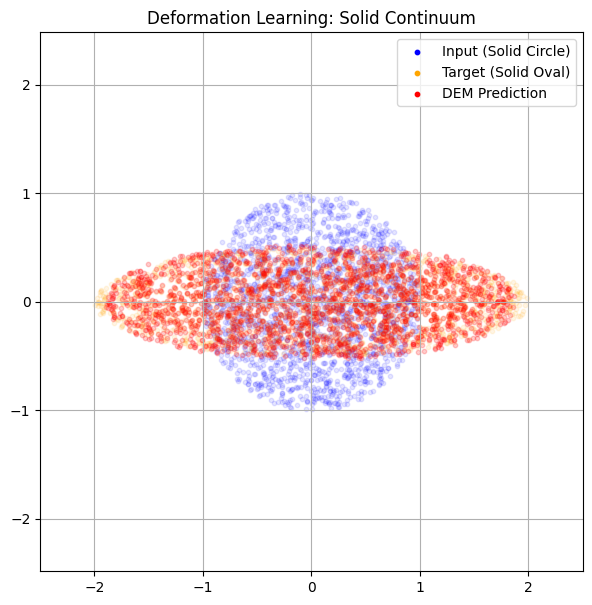

In [7]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt

# --- 1. Material Constants ---
C1 = 0.5   # Shear modulus
D1 = 5.0   # Compressibility penalty

# --- 2. Data Generation (Updated for Solid Object) ---
def get_data(n_samples=2000, key=jax.random.PRNGKey(0)):
    k1, k2 = jax.random.split(key)
    
    # Generate points RANDOMLY inside the unit circle
    # We use sqrt(uniform) for radius to ensure uniform density
    r = jnp.sqrt(jax.random.uniform(k1, (n_samples, 1), minval=0, maxval=1.0))
    theta = jax.random.uniform(k2, (n_samples, 1), minval=0, maxval=2*jnp.pi)
    
    # 1. Input: Solid Circle (Material Coordinates X)
    X_solid = jnp.concatenate([r * jnp.cos(theta), r * jnp.sin(theta)], axis=1)
    
    # 2. Target: Solid Oval (Spatial Coordinates x)
    # This defines the map: x = 2X, y = 0.5Y
    x_target_solid = jnp.concatenate([2.0 * X_solid[:, 0:1], 0.5 * X_solid[:, 1:2]], axis=1)
    
    return X_solid, x_target_solid

# --- 3. The Model ---
class HyperElasticNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Initialize hidden layers
        init_w = nn.initializers.variance_scaling(0.01, mode='fan_in', distribution='truncated_normal')
        
        y = nn.Dense(64, kernel_init=init_w)(x)
        y = nn.tanh(y) 
        y = nn.Dense(64, kernel_init=init_w)(y)
        y = nn.tanh(y)
        
        # Output displacement u
        u = nn.Dense(2, kernel_init=nn.initializers.zeros)(y) 
        return u

# --- 4. Custom Energy Function ---
def custom_energy(model_apply, params, x):
    """
    Equation: W = C1(I1 - 2 - 2ln(J)) + D1(J - 1)^2
    """
    # 1. Kinematics: x -> x + u
    def deformation_map(x_point):
        u = model_apply({'params': params}, x_point[None, :])[0]
        return x_point + u

    # Gradient F
    F = jax.jacfwd(deformation_map)(x)
    
    # Invariants
    C_tensor = F.T @ F
    I1 = jnp.trace(C_tensor)
    J = jnp.linalg.det(F)
    
    # Safe log
    J_safe = jnp.maximum(J, 1e-6)
    
    # 2. The Equation
    # Term 1: Shear/Distortion
    term1 = C1 * (I1 - 2.0 - 2.0 * jnp.log(J_safe))
    
    # Term 2: Volumetric Penalty
    term2 = D1 * (J_safe - 1.0)**2
    
    return term1 + term2

batch_energy_fn = jax.vmap(custom_energy, in_axes=(None, None, 0))

# --- 5. Loss Function ---
@jax.jit
def train_step(state, X_solid, x_target_solid):
    def loss_fn(params):
        # A. Supervised Loss (Geometric Matching)
        # We calculate the error for the WHOLE solid object now
        u_pred = state.apply_fn({'params': params}, X_solid)
        x_pred = X_solid + u_pred
        loss_data = jnp.mean((x_pred - x_target_solid) ** 2)
        
        # B. Physics Loss (Energy Minimization)
        # We calculate energy density for every point in the solid object
        energy_densities = batch_energy_fn(state.apply_fn, params, X_solid)
        loss_physics = jnp.mean(energy_densities)
        
        # Weighting: Heavily favor data matching, use physics as regularizer
        total_loss = 100.0 * loss_data + 1.0 * loss_physics
        return total_loss, (loss_data, loss_physics)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (l_data, l_phys)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, l_data, l_phys

# --- 6. Main Execution ---
def main():
    # Setup
    X_solid, x_target_solid = get_data(n_samples=2000)
    
    model = HyperElasticNet()
    rng = jax.random.PRNGKey(42)
    params = model.init(rng, jnp.ones([1, 2]))['params']
    
    # Scheduler: 1e-3 -> 1e-5
    total_steps = 15000
    scheduler = optax.cosine_decay_schedule(
        init_value=1e-3, decay_steps=total_steps, alpha=0.01
    )
    
    tx = optax.adam(learning_rate=scheduler)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    
    print(f"Training Solid Continuum Model ({C1=}, {D1=})...")

    for step in range(total_steps):
        # We pass the same solid data for both data-matching and physics
        state, loss, l_data, l_phys = train_step(state, X_solid, x_target_solid)
        
        if step % 1000 == 0:
            cur_lr = scheduler(step)
            print(f"Step {step} | LR: {cur_lr:.6f} | Loss: {loss:.5f} | Energy: {l_phys:.5f}")

    # --- 7. Visualization (Updated for Solid Scatter) ---
    
    # Predict deformation on the input data itself
    u_pred = state.apply_fn({'params': state.params}, X_solid)
    X_deformed = X_solid + u_pred

    plt.figure(figsize=(7, 7))
    
    # 1. Input (Solid Circle) - Blue Dots
    plt.scatter(X_solid[:, 0], X_solid[:, 1], 
                alpha=0.1, color='blue', s=10, label='Input (Solid Circle)')
    
    # 2. Target (Solid Oval) - Orange Dots (Background reference)
    plt.scatter(x_target_solid[:, 0], x_target_solid[:, 1], 
                alpha=0.1, color='orange', s=10, label='Target (Solid Oval)')
    
    # 3. NN Prediction - Red Dots (Should overlap Orange)
    plt.scatter(X_deformed[:, 0], X_deformed[:, 1], 
                alpha=0.2, color='red', s=10, label='DEM Prediction')
    
    plt.title("Deformation Learning: Solid Continuum")
    
    # FIX: Use 'legend_handles' instead of 'legendHandles'
    lgnd = plt.legend()
    for handle in lgnd.legend_handles:
        handle.set_alpha(1.0)
        
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    
    plt.show()

if __name__ == "__main__":
    main()